# Problem Set 5, due March 9 at 6:00 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [310]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [311]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

#drop nas 
reviews.dropna(inplace = True)
movies.dropna(inplace = True)

print(list(reviews.columns.values))
print(list(movies.columns.values))
reviews.head()
len(reviews)

['critic', 'fresh', 'imdb', 'link', 'publication', 'quote', 'review_date', 'rtid', 'title']
['id', 'title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year', 'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore', 'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh', 'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating', 'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL']


12718

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [312]:
print ('Number of reviews: %i' % len(reviews))
print ('Number of unique reviewers: %i' % len(reviews.critic.unique()))
print ('Number of unique movies in "reviews": %i' % len(reviews.title.unique()))
print ('Number of unique movies in "movies": %i' % len(movies.title.unique()))
print ('Number of different publications in "reviews": %i' % len(reviews.publication.unique()))


Number of reviews: 12718
Number of unique reviewers: 540
Number of unique movies in "reviews": 1715
Number of unique movies in "movies": 8959
Number of different publications in "reviews": 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Text(0.5,1,'Number of Reviews per Reviewer')

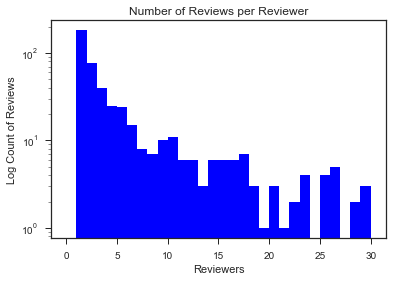

In [313]:
# plot the histogram  
plt.hist(reviews.critic.value_counts(), color='blue', bins = 30, range=(0,30),log = True)

# apply labels
plt.gca().set_xlabel('Reviewers')
plt.gca().set_ylabel('Log Count of Reviews')
plt.gca().set_title('Number of Reviews per Reviewer')

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [314]:
rank_30 = reviews.groupby(['critic']).count().sort_values(by='quote',ascending = False)[:30]
names = (rank_30.index.to_series()).get_values()
first_review = []
last_review = []
pubs = []
for name in names:
    name_pubs = reviews[reviews['critic'] == name]['publication'].unique()
    first_review.append(list(reviews[reviews['critic'] == name]['review_date'].sort_values())[0])
    last_review.append(list(reviews[reviews['critic'] == name]['review_date'].sort_values(ascending = False))[0])
    pubs.append(name_pubs)
            
top_30_info = {'publications':pubs, 'first_review': first_review, 'last_review':last_review}
top_30_info_df = pd.DataFrame(top_30_info).set_index(names)
top_30_info_df

,first_review,last_review,publications
Roger Ebert,2000-01-01 00:00:00,2013-06-11 00:00:00,"[Chicago Sun-Times, At the Movies]"
James Berardinelli,1800-01-01 00:00:00,2012-02-07 00:00:00,[ReelViews]
Janet Maslin,2000-01-01 00:00:00,2010-09-07 00:00:00,[New York Times]
Variety Staff,2001-02-13 00:00:00,2012-08-15 00:00:00,[Variety]
Jonathan Rosenbaum,1988-07-11 00:00:00,2013-10-22 00:00:00,[Chicago Reader]
Desson Thomson,2000-01-01 00:00:00,2012-10-08 00:00:00,[Washington Post]
Geoff Andrew,2005-08-11 00:00:00,2012-04-05 00:00:00,[Time Out]
Dave Kehr,2000-01-01 00:00:00,2013-11-20 00:00:00,"[Chicago Reader, New York Daily News, Chicago ..."
Kenneth Turan,2000-01-01 00:00:00,2013-10-05 00:00:00,[Los Angeles Times]
Mick LaSalle,2000-01-01 00:00:00,2009-11-25 00:00:00,[San Francisco Chronicle]


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


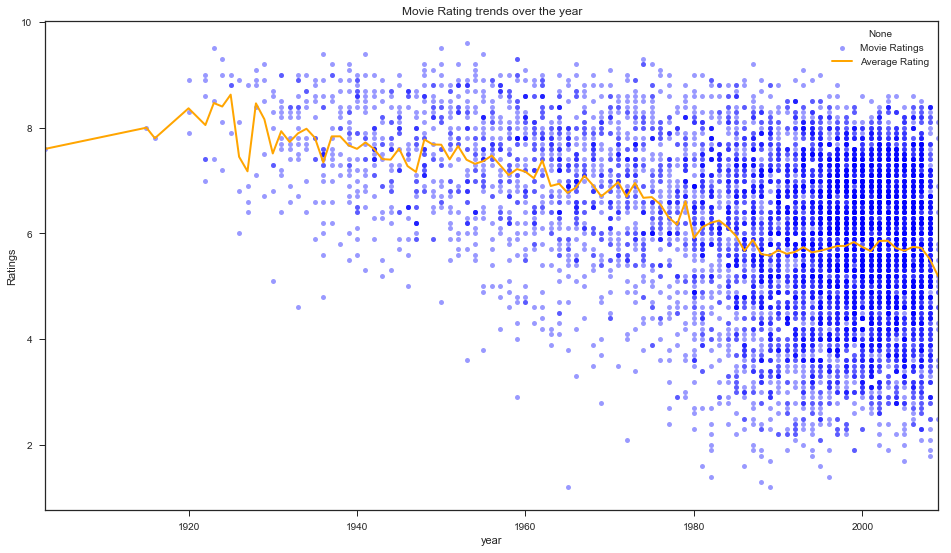

In [315]:
   
#to numeric
movies.rtAllCriticsRating = pd.to_numeric(movies.rtAllCriticsRating)

#getting a copy to df
movies_df = pd.DataFrame(movies)

#removing zeros and getting sub-df for graph
rating_by_year = movies_df[~(movies_df.rtAllCriticsRating == 0)][['year','rtAllCriticsRating']]
means_by_year = pd.DataFrame(rating_by_yr.groupby(['year'],as_index=False)['rtAllCriticsRating'].agg('mean'))


#plotting
plt.figure(figsize=(16,9))
ax = plt.scatter(rating_by_yr.year,rating_by_yr.rtAllCriticsRating, alpha=0.4, s = 25, c = 'blue',lw=0,label='Movie Ratings')
ax = plt.axes()
plt.title("Movie Rating trends over the year")
plt.xlabel("Year")
plt.ylabel("Ratings")
plt.legend()

means_by_year.plot(kind='line', x='year', y='rtAllCriticsRating', c = 'orange', ax=ax\
                    , label='Average Rating', linewidth=2)

There are many more ratings for movies starting form the 80s. The distribution of ratings since then is pretty sparce. However critics seems to favor "vintage" movies in that if they're before the 80s they stay mostly above the average line.This might have to do with availability - the old movies retained for review is because they're classics (selection bias). Movies scores over all also tend down as time goes by.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [316]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print ("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x

print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules
Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]
Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [319]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None, min_df = None):
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df)
    vectorizer.fit(reviews.quote)
    x = vectorizer.transform(reviews.quote)
    X = x.toarray()
    Y = (reviews.fresh == 'fresh').values.astype(np.int)
    Features = vectorizer.get_feature_names()
    return X, Y

In [320]:
X, Y= make_xy(reviews)
len(X)

12718

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [322]:
# enter your code here
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 100)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(9538, 20267) (9538,)
(3180, 20267) (3180,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [323]:
# enter your code here
import sklearn.naive_bayes as nb
# call the fitted model fitted_model, for future reference:
fitted_model = nb.MultinomialNB()
fitted_model.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_test,y_test)))

Model with TRAIN alpha 1.000, the score is 0.927867
Model with TEST alpha 1.000, the score is 0.783962


NB performed very well on train data but not on test data, suggesting overfitting.

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [325]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test, y_test)

-1762.7115392029139

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [326]:
warnings.filterwarnings(action='ignore') #remove user warning regarding alpha too small

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        #set vectorizer
        vectorizer = CountVectorizer(min_df = min_df)   
        #build word of bag and y
        X, Y = make_xy(reviews, vectorizer)
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        # estimate log likelihood on test data
        score = cross_val_score(fitted_model, X, Y, scoring = log_likelihood).mean()
        
        # update best values
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df

print ("Best_alpha = ",best_alpha, "Best_min_df = ", best_min_df, "Max_loglike = ", max_loglike)

warnings.filterwarnings(action='default') #resetting to default warning

Best_alpha =  5 Best_min_df =  0.001 Max_loglike =  -2353.07320543


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [327]:
#getting x y
X, Y = make_xy(reviews, vectorizer=None, min_df = best_min_df)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 100)

# call the fitted model fitted_model, for future reference:
fitted_model = nb.MultinomialNB(alpha = best_alpha)
fitted_model.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_test,y_test)))

Model with TRAIN alpha 5.000, the score is 0.745334
Model with TEST alpha 5.000, the score is 0.677987


test and train score are much close to one another, so we solved the over fitting problem through cross validation, however the accuracy also went down (or simply more realistic). Raising alpha and df seemed to impact the result significantly. Since we raied min_df, we removed some infrequent words, resulting some of the words not being mapped and decreased accuracy. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [328]:
warnings.filterwarnings(action='ignore') #remove user warning regarding alpha too small

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_score = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        #set vectorizer
        vectorizer = CountVectorizer(min_df = min_df)   
        #build word of bag and y
        X, Y = make_xy(reviews, vectorizer)
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        # estimate log likelihood on test data
        score = cross_val_score(fitted_model, X, Y, scoring = 'accuracy').mean()
        
        # update best values
        if score > best_score:
            best_score = score
            best_alpha = alpha
            best_min_df = min_df

print ("Best_alpha = ",best_alpha, "Best_min_df = ", best_min_df, "best_score = ", best_score)

warnings.filterwarnings(action='default') #resetting to default warning

#getting x y
make_xy(reviews, vectorizer=None, min_df = best_min_df)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 100)

# call the fitted model fitted_model, for future reference:
fitted_model = nb.MultinomialNB(alpha = best_alpha)
fitted_model.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(fitted_model.alpha, fitted_model.score(X_test,y_test)))


Best_alpha =  1 Best_min_df =  1e-05 best_score =  0.763406295541
Model with TRAIN alpha 1.000, the score is 0.625288
Model with TEST alpha 1.000, the score is 0.629560


When changed the method to accuraccy, the result didn't change that much, but it did choose a different alpha and min_df (much smaller). This makes me think about "GIGO" in that perhaps our data was resulting the accuracy issue not the model. Perhaps the data was too sparse to start with with not significant enough indicator. Maybe we should do a round of feature selection instead?

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [329]:
def make_xy_with_features(reviews, vectorizer=None, min_df = None):
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df = min_df)
    vectorizer.fit(reviews.quote)
    x = vectorizer.transform(reviews.quote)
    X = x.toarray()
    Y = (reviews.fresh == 'fresh').values.astype(np.int)
    Features = vectorizer.get_feature_names()
    return X, Y, Features

In [330]:
# set up vectorizer using 3.3 result
vectorizer = CountVectorizer(min_df = .001)       

#get x y 
X, Y, Features = make_xy_with_features(reviews)

# fit model
fitted_model = MultinomialNB(alpha=5)
fitted_model.fit(X, Y)

# get probabilities for each term
probs = pd.DataFrame(fitted_model.predict_proba(np.identity(len(Features))), columns = ['rotten_probs', 'fresh_probs'])
probs['features'] = Features
probs = probs.set_index('features')

# get rotten words and their prob and sorted
rotten_probs = probs.sort_values(['rotten_probs'],ascending = False).drop('fresh_probs',1)
print ("top rotten word predict probabilities")
print ("------------------------")#line break
print (rotten_probs.head(10))
print ("------------------------")#line break

# get fresh words and their prob and sorted
fresh_probs = probs.sort_values(['fresh_probs'],ascending = False).drop('rotten_probs',1)
print ("top fresh word predict probabilities")
print ("------------------------")#line break
print (fresh_probs.head(10))


top rotten word predict probabilities
------------------------
                rotten_probs
features                    
unfortunately       0.882942
lame                0.856529
pointless           0.843561
uninspired          0.833531
bland               0.828017
unfunny             0.806674
disappointment      0.806674
tiresome            0.801753
dull                0.801063
sadly               0.785364
------------------------
top fresh word predict probabilities
------------------------
               fresh_probs
features                  
delight           0.905253
masterpiece       0.903351
touching          0.876867
intelligent       0.875156
rare              0.874787
superb            0.870974
remarkable        0.870974
stunning          0.867160
witty             0.865570
extraordinary     0.864489


What's wrong with critics that "unfunny" = bad? 
Just kidding. If the critic think your work is unfortunate 
then you're in a very bad place, 
but sometimes they just tell you they think you're lame. 
and that your movie is pointless. 
Which is a good thing - at least you know where you did "wrong".
If you let them have a lot of feels. 
So they don't think you work is dull or uninspired, 
and instead they think it's touching, intelligent, 
and overall a delight and a masterpiece
then get ready for a round of applause! 
Again, they want to be entertained. 
Look, wittiness is 86% likely getting you a good review, 
so just make an effort and them laugh eh? 
Oh, and it appears if you are smart about your funny, then you're winning the hearts!!

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [331]:
# set up vectorizer using 3.3 result
vectorizer = CountVectorizer(min_df = .001)       

#get x y 
X, Y, Features = make_xy_with_features(reviews, vectorizer)

# fit model
fitted_model = MultinomialNB(alpha=5)
fitted_model.fit(X, Y)
probs = fitted_model.predict_proba(X)

#getting fresh:
gaps = abs(Y-probs[:,1])
summary = {'probs': probs[:,1], 'Y': Y, 'gaps': gaps, 'reviews': reviews.quote}
summary = pd.DataFrame(summary)
summary = summary[summary.Y == 1].sort_values('gaps', ascending = False)
top_gap_fresh = summary.head(6)
top_gap_fresh = top_gap_fresh.reset_index()
for i in range(len(top_gap_fresh)):
    print ("This is top ", i,  " gap in missed fresh prediction")
    print (top_gap_fresh['reviews'][i])
    print ("--------------------")
    
#getting rottten
gaps = abs(Y-probs[:,1])
summary = {'probs': probs[:,1], 'Y': Y, 'gaps': gaps, 'reviews': reviews.quote}
summary = pd.DataFrame(summary)
summary = summary[summary.Y == 0].sort_values('gaps', ascending = False)
top_gap_rotten = summary.head(6)
top_gap_rotten = top_gap_rotten.reset_index()
for i in range(len(top_gap_rotten)):
    print ("This is top ", i,  " gap in missed rotten prediction")
    print (top_gap_rotten['reviews'][i])
    print ("--------------------")


This is top  0  gap in missed fresh prediction
Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?
--------------------
This is top  1  gap in missed fresh prediction
Though it's a good half hour too long, this overblown 1993 spin-off of the 60s TV show otherwise adds up to a pretty good suspense thriller.
--------------------
This is top  2  gap in missed fresh prediction
There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.
--------------------
This is top  3  gap in missed fresh prediction
The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent than Ace Ventura.
--------------------
This is top  4  gap 

Looking at fresh wrongly predited, the words are mostly taken out of context. For example it doesn't take double negative as positive, and it doesn't consider transitional words like "but", not does it consider POS. In rotton wrongly predicted the wording are more vague, otherwise it's the same issue as fresh. Some cases are "good" and "bad" words both exist. If I were to do this again, I would have done chuncked words and NER first, then move on to experiments.

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [332]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Text(0.5,1,'Per capita crime rate vs median home values')

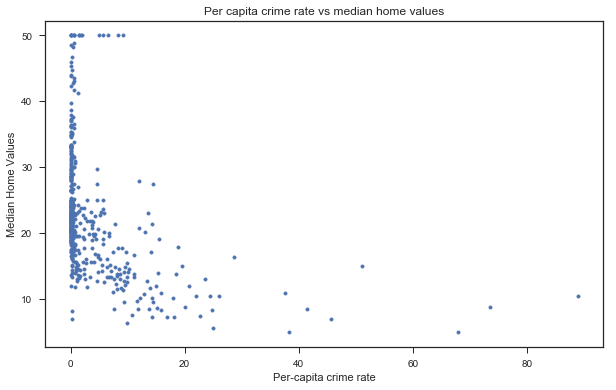

In [333]:
# plot median home value and per capita crime

%matplotlib inline 
df = pd.DataFrame(bdata.data, columns=bdata.feature_names)
df['target'] = bdata.target
plt.figure(figsize=(10,6))
plt.scatter(df['CRIM'],df['target'],marker = ".")
plt.ylabel('Median Home Values')
plt.xlabel('Per-capita crime rate')
plt.title("Per capita crime rate vs median home values")



Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

In [334]:
#RMSE from PS3
def compute_rmse(predictions, yvalues):
    from math import sqrt
    from sklearn import metrics
    rmse = sqrt(metrics.mean_squared_error(yvalues, predictions))
    return rmse

#train test split
np.random.seed(seed=13579)
df['rand'] = (np.random.uniform(0,1,506))
df['train'] = (df['rand']>(1-0.667))
df_test = df[df.train == False]
df_train = df[df.train == True]

#train regression model
from sklearn import datasets, linear_model
#set up regression
regr = linear_model.LinearRegression()
#fix x y
regr.fit(df_train[['RM']],df_train[['target']])
#predict y
y_pred_test = regr.predict(df_test[['RM']])
y_pred_train = regr.predict(df_train[['RM']])

rmse_test = compute_rmse(y_pred_test, df_test[['target']])
rmse_train = compute_rmse(y_pred_train, df_train[['target']])

print ("rest test = ", rmse_test,"rmse_train = ", rmse_train)


rest test =  6.724751059994966 rmse_train =  6.565980908743782


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

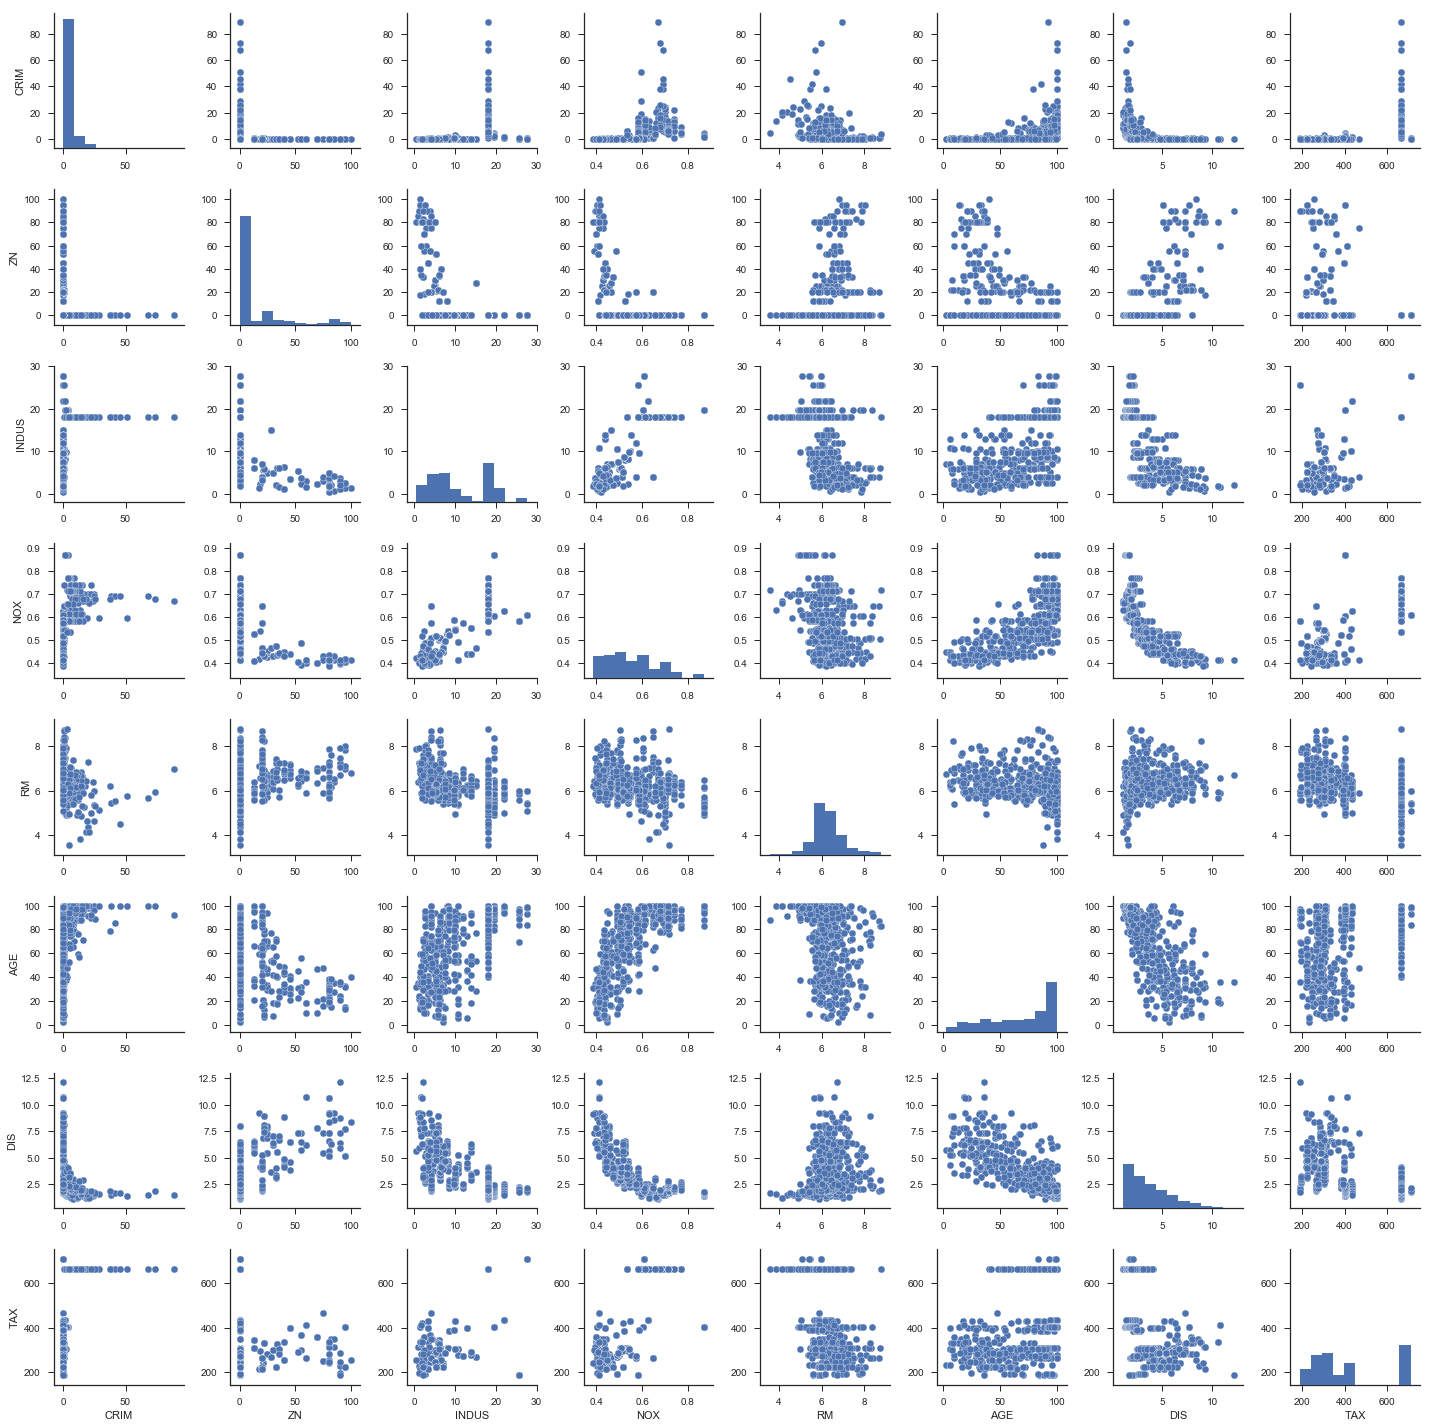

In [335]:
import seaborn as sns
#select featuers of interest
features_data = df[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX']]

sns.set(style="ticks")

sns.pairplot(features_data)


### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

the optimal is up to 5


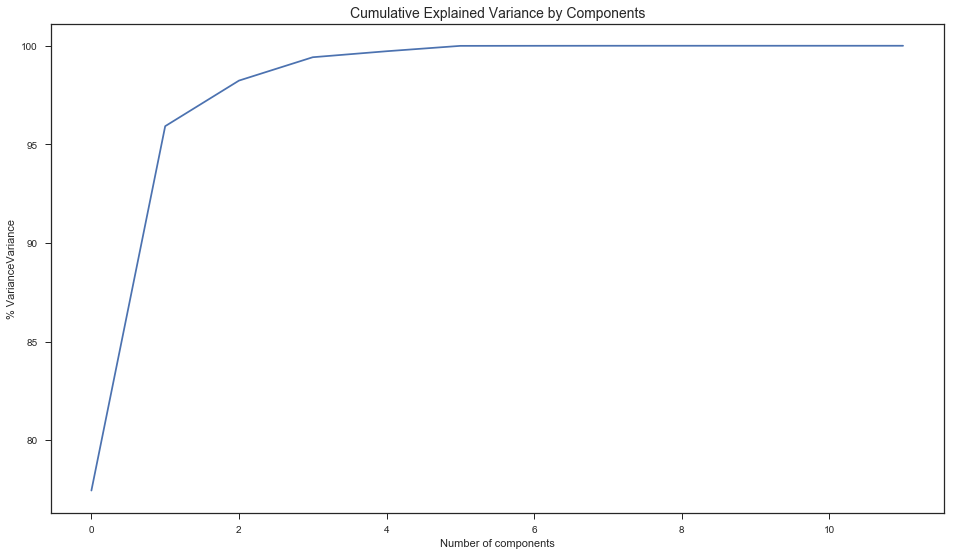

In [336]:
pca = PCA(n_components=12)
pca.fit(df_train[:13])
plt.figure(figsize=(16,9))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.ylabel('% VarianceVariance')
plt.xlabel('Number of components')
plt.title('Cumulative Explained Variance by Components', fontsize = 14)
print ("the optimal is up to 5")

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

Text(0.5,1,'PCA 2 vs. median housing value')

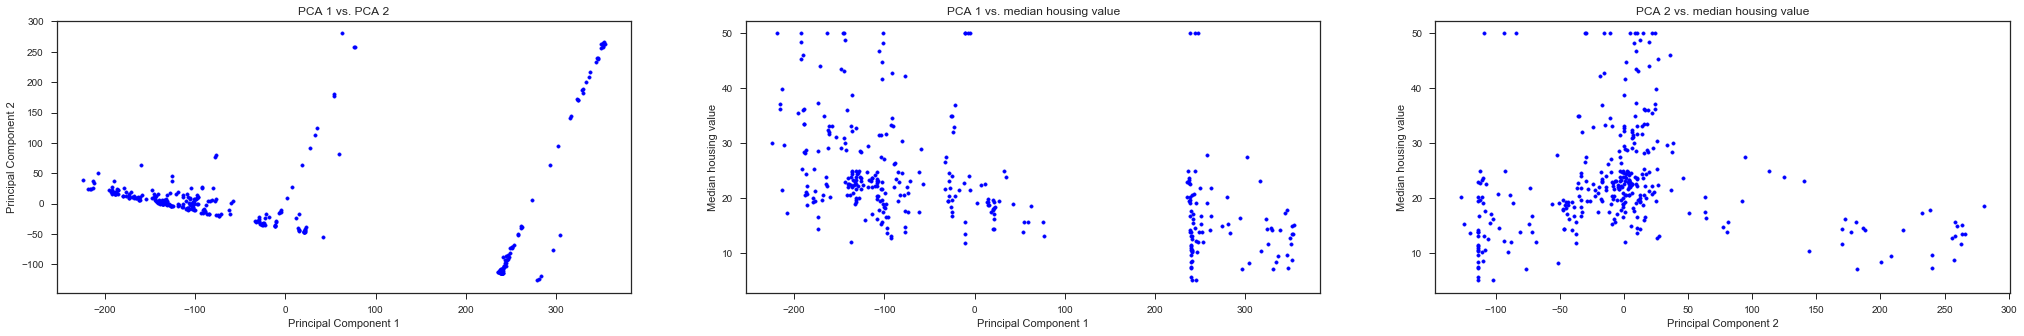

In [337]:

fig = plt.figure(figsize=(35,5)) 

ax1 = fig.add_subplot(1,3,1) 
pca1 = pca.fit_transform(df_train)[:,0]
pca2 = pca.fit_transform(df_train)[:,1]
plt.scatter(pca1,pca2,marker = ".", c = "blue")
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title("PCA 1 vs. PCA 2")

ax2 = fig.add_subplot(1,3,2) 
pca1 = pca.fit_transform(df_train)[:,0]
plt.scatter(pca1,df_train['target'],marker = ".", c = "blue")
plt.ylabel('Median housing value')
plt.xlabel('Principal Component 1')
plt.title("PCA 1 vs. median housing value")

ax1 = fig.add_subplot(1,3,3) 
pca1 = pca.fit_transform(df_train)[:,1]
plt.scatter(pca1,df_train['target'],marker = ".", c = "blue")
plt.ylabel('Median housing value')
plt.xlabel('Principal Component 2')
plt.title("PCA 2 vs. median housing value")

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [338]:
# fit PCA with 1 component
pca1 = PCA(n_components = 1)
df_x = df.drop('target',axis =1)
pca1.fit(df_x)

# transform using training and test data
df_x_train = df_train.drop('target',axis =1)
pca1_train = pca1.fit_transform(df_train)
df_x_test = df_test.drop('target',axis =1)
pca1_test = pca1.fit_transform(df_test)


In [340]:
#set up regression
regr = linear_model.LinearRegression()
#fix x y
regr.fit(df_x_train,df_train[['target']])
#predict y
y_pred_test = regr.predict(df_x_test)
y_pred_train = regr.predict(df_x_train)

rmse_test = compute_rmse(y_pred_test, df_test[['target']])
rmse_train = compute_rmse(y_pred_train, df_train[['target']])

print ("rmse test = ", rmse_test,"rmse_train = ", rmse_train)

rmse test =  4.6384371352053275 rmse_train =  4.752650843715073


before PCA,  rmse results are: test =  6.72 train =  6.57

after PCA, rmse results are: test = 4.64 train = 4.75

Neither before or after had big changes between test and train rmse. However overall the rmse went down, so the model with PCA did have better results. 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
from collections import Counter, defaultdict



def get_prior(data):
    X, Y, Features = make_xy_with_features(data)
    total_outcomes = len(Y)
    prob = dict(Counter(Y))
    for key in prob.keys():
        prob[key] = prob[key] / float(total_outcomes)
    return prob

def get_feature_prob(data):
    df = make_xy_with_features(reviews)
    #get y class
    y_class, class_counts = np.unique(df[:,1], return_counts=True)
    feature_conditionals = []
    #get likelyhood for each x
    for cl in y_class:
        #filter by class
        x_by_class = xtrain[np.where(Y==cl)]
        #turn into feature likelyhood
        feature_likelyhood = x_by_class.sum(axis=0).astype(float)/len(x_by_class.sum(axis=0))
        feature_conditionals.append(x_likelyhood)
        #update to array for calc
    feature_conditionals = np.array(conditionals)
    return feature_conditionals 
        
def get_x_conditional(data):
    
    
def predict_y (data):
